In [5]:
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from long_covid.colors import flatuicolors
from long_covid import styling

In [47]:
# Globally accessible input data
WEEKLY_DEVIATIONS = pd.read_feather('../data/03_derived/weekly_vital_deviations_per_user.feather')
COHORTS = pd.read_feather('../data/03_derived/user_cohorts.feather')

# Global variables for styling
COHORT_KEYS = ['negative', 'vaccinated', 'unvaccinated'] 
LABELS = [key.capitalize() for key in COHORT_KEYS]
COLORS = [flatuicolors.belizehole, flatuicolors.amethyst, flatuicolors.pomegranate]
X_LABELS = ['RHR increase [bpm/day]', 'Activity reduction [steps/day]', 'Sleep increase [min/day]']
VITAL_IDS = [65, 9, 43]
BAR_OFFSET = [-1.15, 0, 1.15]
BINS = [np.arange(-1, 12, 2), np.arange(-11000, 2000, 2000), np.arange(-15, 180, 30)]
BIN_LABELS = [
    ('<1', '2', '4', '6', '8', '>9'), 
    ['<1000', '2000', '4000', '6000', '8000', '>9000'][::-1],
    ('<15', '30', '60', '90', '120', '>135')
]

OUTFILE = '../output/figure3_change_frequencies.jpg'

In [50]:
def vital_change_distributions(outfile):

    # Obtain list of user ids for each cohort
    cohorts = [COHORTS.user_id[COHORTS[key]].values for key in COHORT_KEYS]     
    
    f, axarr = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

    # Iterate over every cohort
    for (offset, color, label, cohort) in zip(BAR_OFFSET, COLORS, LABELS, cohorts):
    
        # Iterate over all vitals
        for ax, vital, bins, xlabel, binlabel in zip(axarr, VITAL_IDS, BINS, X_LABELS, BIN_LABELS):

            # Get all weekly per-user deviations in the first month after a test
            a = WEEKLY_DEVIATIONS[
                (WEEKLY_DEVIATIONS.vitalid == vital) & 
                WEEKLY_DEVIATIONS.weeks_since_test.between(0, 4)
            ]

            # Set all values smaller than the minimum bin to the minimum bin
            a.loc[a.vital_change < bins[0], 'vital_change'] = bins[0]
            
            # Likewise, set all values larger than the maximum bin to the maximum bin
            a.loc[a.vital_change > bins[-1], 'vital_change'] = bins[-1]

            # Compute relative frequencies for the considered cohort
            count, x = np.histogram(a[a.userid.isin(cohort)].vital_change, bins=bins)
            count = count / len(a[a.userid.isin(cohort)])
        
            # Center x-values at the center of each bin
            x = x[:-1] + np.diff(x)[0] / 2
            width = np.diff(x)[0] / 3 * .7

            # Flip the sign so that reduction of steps has a positive value
            if vital == 9:
                x *= -1

            # Draw the bars
            ax.bar(x + offset * width, count, width=width, color=color, label=label)
            ax.set_xticks(x)
            

    # Style the plot
    axarr[0].set_ylabel('Relative frequency', size=12)
    axarr[0].legend(loc='center right', frameon=False)
    
    for ax, xlabel, binlabel in zip(axarr, X_LABELS, BIN_LABELS):
        styling.hide_and_move_axis(ax)
        ax.set_xlabel(xlabel, size=12)
        ax.set_xticklabels(binlabel)
            
    # Add labels
    axarr[0].text(10, .61, 'A', size=24)
    axarr[1].text(10000, .61, 'B', size=24)
    axarr[2].text(150, .61, 'C', size=24)

    plt.tight_layout()
    plt.savefig(outfile, dpi=400)

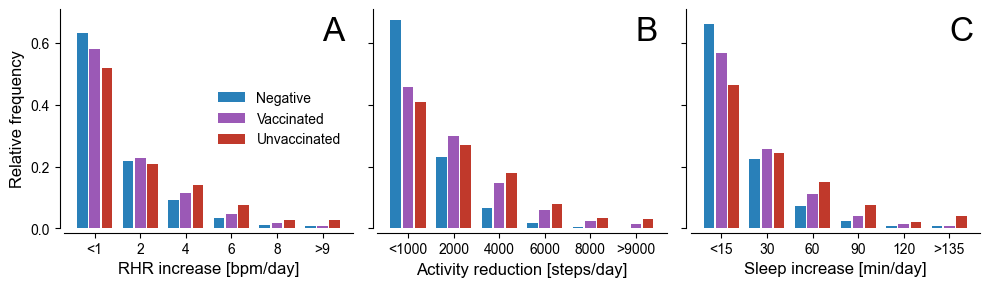

In [51]:
vital_change_distributions(OUTFILE)